In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.plotting.movies_mmWave_data import MovieGeneratorMmWaveData

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"6843_RadVel_ods_10Hz.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

dataset_name = "CPSL_RadVel_ods_10Hz_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

/data/RadVel/CPSL_RadVel_ods_10Hz_1
found 452 radar samples
did not find lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 452 vehicle velocity samples
found 452 vehicle odometry samples


In [3]:
#load the plotter
plotter = PlotterMmWaveData(config_manager=cfg_manager)
plotter.min_threshold_dB = 60

#initialize a range azimuth processor
range_az_processor = RangeAngleProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#initialize the range doppler processor
range_doppler_processor = RangeDopplerProcessor(
    config_manager=cfg_manager
)

doppler_azimuth_processor = DopplerAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

micro_doppler_processor = MicroDopplerProcessor(
    config_manager=cfg_manager,
    target_ranges=np.array([3.0,3.7]),
    num_frames_history=20
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

#initialize the movie generator
movie_generator = MovieGeneratorMmWaveData(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_azimuth_processor=range_az_processor,
    range_doppler_processor=range_doppler_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

found temp dir: /home/david/Downloads/RadVel/CPSL_RadVel_ods_10Hz_1
clearing temp directory /home/david/Downloads/RadVel/CPSL_RadVel_ods_10Hz_1


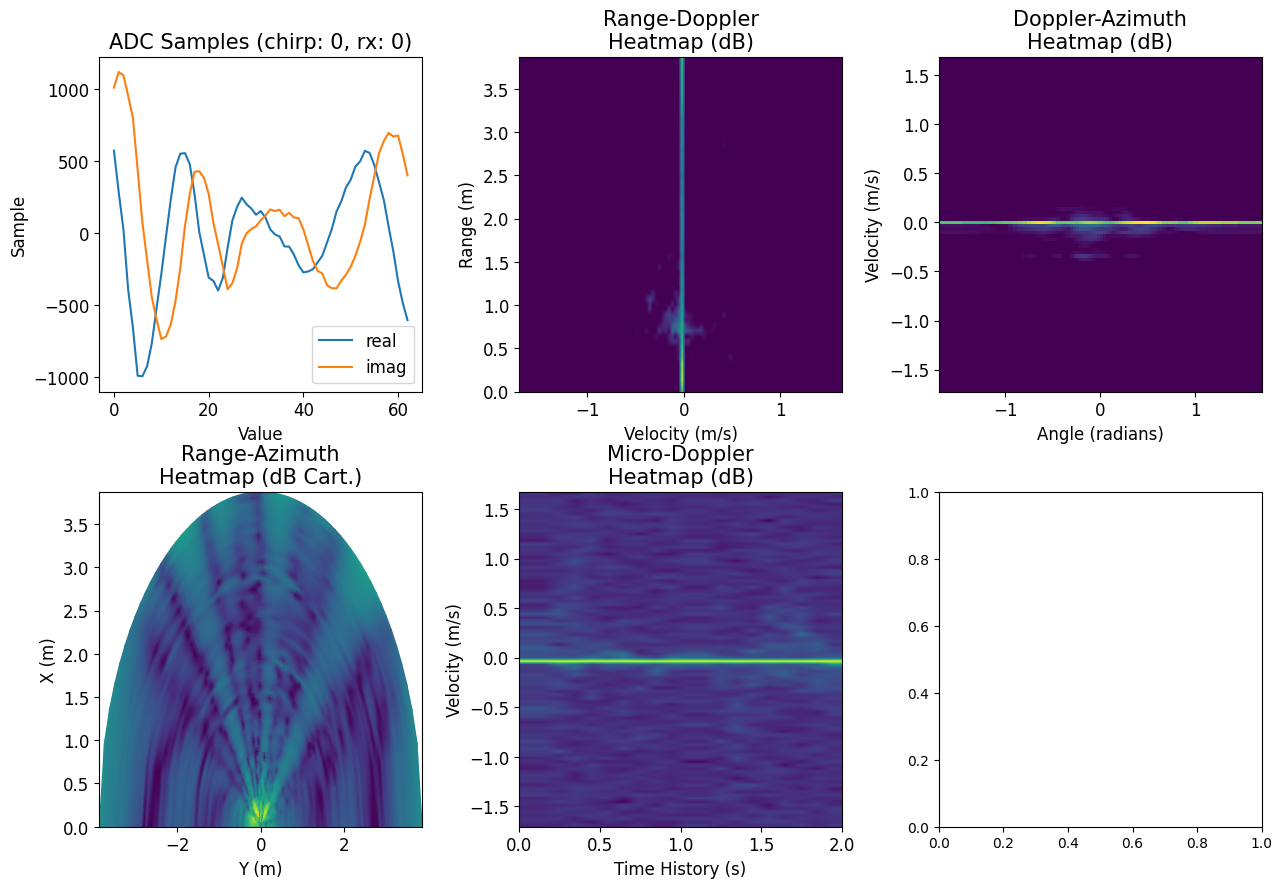

In [4]:
#for getting access to the adc cube
idx=0
#compute responses over a series of frames
for i in range(micro_doppler_processor.num_frames_history):

    #get the ADC cube
    adc_cube = dataset.get_radar_data(idx + i)

    adc_cube = virtual_array_reformatter.process(adc_cube)
    rng_az_resp = range_az_processor.process(adc_cube=adc_cube,chirp_idx=0)
    rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
    dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)
    micro_doppler_resp = micro_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)

    try:
        camera_view = dataset.get_camera_frame(idx + i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(2,3, figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    range_doppler_processor=range_doppler_processor,
    range_azimuth_processor=range_az_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    chirp_idx=0,
    rx_antenna_idx=0,
    axs=axs,
    show=True
)

Estimated altitude: 0.90 m


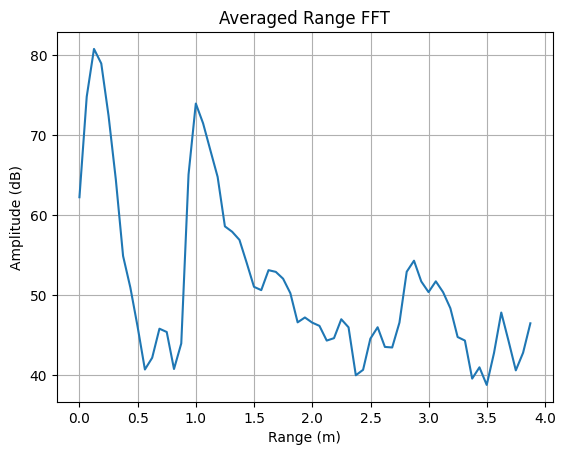

In [5]:
# Get the odometry estimate
idx = 150
vehicle_odom = dataset.get_vehicle_odom_data(idx=idx)
vehicle_vel = np.average(vehicle_odom[:, 3])
print(f"Estimated altitude: {vehicle_vel:.2f} m")

# Compute range FFT parameters
range_bins = np.arange(
    start=0,
    step=cfg_manager.range_res_m,
    stop=cfg_manager.range_max_m - cfg_manager.range_res_m/2 + 1e-3
)

# Get the ADC cube and format
adc_cube = dataset.get_radar_data(idx)
adc_cube = virtual_array_reformatter.process(adc_cube)

# Select chirp across all receivers
chirp_idx = 0
rx_data = adc_cube[:, :, chirp_idx]  # shape: (num_rx, num_samples)

# Apply Hanning window to each RX signal
hanning_window = np.hanning(rx_data.shape[1])
rx_data_windowed = rx_data * hanning_window  # broadcasted multiplication

# Compute FFT along the sample axis
fft_result = np.fft.fft(rx_data_windowed, axis=1)

# Compute magnitude and average across receivers
fft_magnitude = np.abs(fft_result)
fft_avg = np.mean(fft_magnitude, axis=0)

# Convert to dB
resp_db = 20 * np.log10(fft_avg + 1e-12)  # avoid log(0)

# Plot
plt.plot(range_bins, resp_db[:len(range_bins)])
plt.xlabel("Range (m)")
plt.ylabel("Amplitude (dB)")
plt.title("Averaged Range FFT")
plt.grid(True)
plt.show()


Peak locations: [0.12491352 0.99930819 2.87301106]


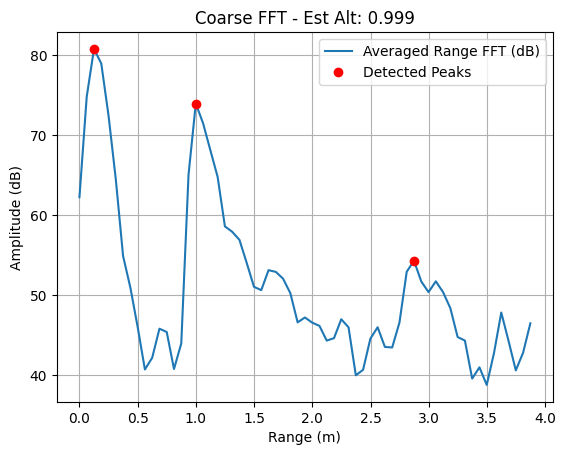

In [6]:
from scipy.signal import find_peaks

# Detect peaks (you can tune height/prominence as needed)
peaks, _ = find_peaks(resp_db, prominence=6)  # adjust threshold as needed

# Filter: Only keep peaks within 30 dB of max peak
peak_vals = resp_db[peaks]
max_peak = np.max(peak_vals)
within_30dB = peak_vals >= (max_peak - 30)
filtered_peaks = peaks[within_30dB]
filtered_vals = peak_vals[within_30dB]

# Sort peaks by magnitude (descending)
sorted_indices = np.argsort(filtered_vals)[::-1]
sorted_peaks = filtered_peaks[sorted_indices]

# Keep top N peaks
N = 3
top_peaks = sorted_peaks[:N]
top_vals = resp_db[top_peaks]
print(f"Peak locations: {range_bins[top_peaks]}")

# Plot averaged FFT with detected peaks
plt.figure()
plt.plot(range_bins, resp_db[:len(range_bins)], label="Averaged Range FFT (dB)")
plt.plot(range_bins[top_peaks], resp_db[top_peaks], 'ro', label="Detected Peaks")
plt.xlabel("Range (m)")
plt.ylabel("Amplitude (dB)")
plt.title(f"Coarse FFT - Est Alt: {range_bins[top_peaks[1]]:0.3f}")
plt.grid(True)
plt.legend()
plt.show()

Estimated altitude: 0.90 m
Coarse range resolution: 0.0625 meters
Zoom FFT range-bin resolution: 0.0065 meters


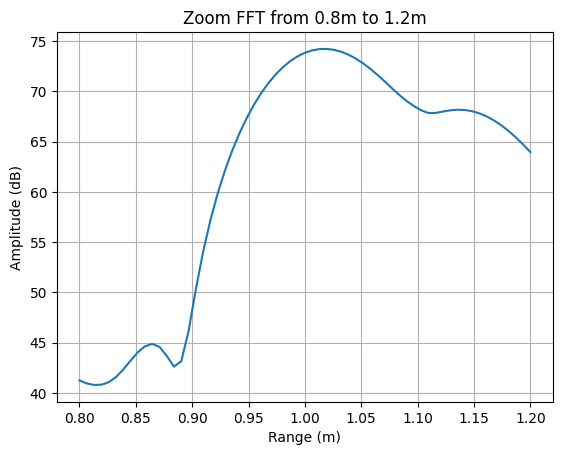

In [7]:
from scipy.signal import ZoomFFT

# Get the odometry estimate
idx = 150
vehicle_odom = dataset.get_vehicle_odom_data(idx=idx)
vehicle_vel = np.average(vehicle_odom[:, 3])
print(f"Estimated altitude: {vehicle_vel:.2f} m")

# Compute range FFT parameters
range_bins = np.arange(
    start=0,
    step=cfg_manager.range_res_m,
    stop=cfg_manager.range_max_m - cfg_manager.range_res_m/2 + 1e-3
)

fs = 1 / cfg_manager.range_res_m  # Effective sampling rate (1 / spacing in meters)
chirp_idx = 0

# Get the ADC cube and format
adc_cube = dataset.get_radar_data(idx)
adc_cube = virtual_array_reformatter.process(adc_cube)

# Select chirp across all receivers
rx_data = adc_cube[:, :, chirp_idx]  # shape: (num_rx, num_samples)

# Apply Hanning window
num_samples = rx_data.shape[1]
hanning_window = np.hanning(num_samples)
rx_data_windowed = rx_data * hanning_window

# Define zoom range in meters
range_start_m = 0.80
range_stop_m = 1.20

# Convert to frequency (Hz) domain equivalent — assuming range_bin spacing is ~linear
freq_start = range_start_m * fs / cfg_manager.range_max_m
freq_stop = range_stop_m * fs / cfg_manager.range_max_m

# Create ZoomFFT instance
zoom = ZoomFFT(num_samples,[freq_start, freq_stop], fs=fs)

# Perform zoom FFT for each RX and average
# Apply ZoomFFT along axis=1 (i.e., along the sample dimension)
zoom_result = zoom(rx_data_windowed, axis=1)  # shape: (num_rx, num_zoom_bins)

# Compute magnitude and average across receivers
zoom_avg = np.mean(np.abs(zoom_result), axis=0)
zoom_db = 20 * np.log10(zoom_avg + 1e-12)  # avoid log(0)


# Create range axis for zoomed-in view
num_zoom_bins = len(zoom_db)
zoom_range = np.linspace(range_start_m, range_stop_m, num_zoom_bins)
range_bin_res_zoom = (range_stop_m - range_start_m) / (num_zoom_bins - 1)
print(f"Coarse range resolution: {cfg_manager.range_res_m:.4f} meters")
print(f"Zoom FFT range-bin resolution: {range_bin_res_zoom:.4f} meters")


# Plot Zoom FFT result
plt.plot(zoom_range, zoom_db)
plt.xlabel("Range (m)")
plt.ylabel("Amplitude (dB)")
plt.title(f"Zoom FFT from {range_start_m:.1f}m to {range_stop_m:.1f}m")
plt.grid(True)
plt.show()

Zoom Peak locations: [1.01935484]


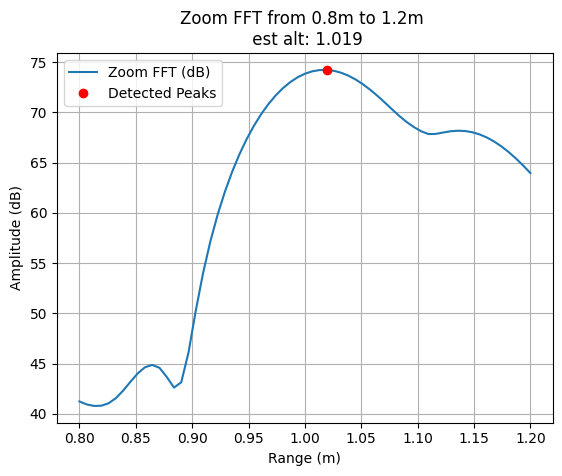

In [8]:
# Detect peaks (you can tune height/prominence as needed)
peaks, _ = find_peaks(zoom_db, prominence=6)  # adjust threshold as needed

# Filter: Only keep peaks within 30 dB of max peak
peak_vals = zoom_db[peaks]
max_peak = np.max(peak_vals)
within_30dB = peak_vals >= (max_peak - 30)
filtered_peaks = peaks[within_30dB]
filtered_vals = peak_vals[within_30dB]

# Sort peaks by magnitude (descending)
sorted_indices = np.argsort(filtered_vals)[::-1]
sorted_peaks = filtered_peaks[sorted_indices]

# Keep top N peaks
N = 3
top_peaks = sorted_peaks[:N]
top_vals = zoom_db[top_peaks]
print(f"Zoom Peak locations: {zoom_range[top_peaks]}")

# Plot averaged FFT with detected peaks
plt.figure()
plt.plot(zoom_range, zoom_db, label="Zoom FFT (dB)")
plt.plot(zoom_range[top_peaks], zoom_db[top_peaks], 'ro', label="Detected Peaks")
plt.xlabel("Range (m)")
plt.ylabel("Amplitude (dB)")
plt.title(f"Zoom FFT from {range_start_m:.1f}m to {range_stop_m:.1f}m \n est alt: {zoom_range[top_peaks[0]]:0.3f}")
plt.grid(True)
plt.legend()
plt.show()